In [1]:
# Cell 1 — Environment & Imports

import os, random, math, glob
from pathlib import Path

# Quiet TF info logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Optional: avoid oneDNN half precision note on some CPUs
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import cv2
from PIL import Image
import scipy.io as sio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

2025-09-26 23:06:32.961566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758906393.135705    6265 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758906393.185049    6265 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758906393.610239    6265 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758906393.610256    6265 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758906393.610257    6265 computation_placer.cc:177] computation placer alr

In [2]:
# Cell 2 — Configuration & Reproducibility

DATA_ROOT = "/home/akif/Desktop/ComputerVision/Assignment_7/archive(5)/ShanghaiTech/part_B"

# Train-time patch size; try 384x384 if you want even faster steps
PATCH_SIZE = (512, 512)
IMG_SIZE   = (512, 512)
BATCH_SIZE = 6
EPOCHS     = 50

# Density kernels
SIGMA = 4.0
USE_ADAPTIVE_SIGMA_TRAIN = False   # <<< speed: fixed sigma during TRAIN
USE_ADAPTIVE_SIGMA_TEST  = True    # keep adaptive for EVAL
KNN_K      = 3
KNN_BETA   = 0.3

# LR scales with batch size
BASE_BATCH = 4
BASE_LR    = 1e-4
LR         = BASE_LR * (BATCH_SIZE / BASE_BATCH)

# tf.data
NUM_PARALLEL = tf.data.AUTOTUNE

# Eval cadence / speed
EVAL_EVERY   = 5       # <<< evaluate every N epochs
EVAL_SUBSET  = 10      # <<< only this many test images per eval
EVAL_OVERLAP = 0.0     # <<< 0.0 is fastest; 0.25 is a bit smoother

# Mixed precision ON; XLA OFF to avoid long cuDNN algorithm searches
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(False)   # <<< disable XLA to remove long autotune pauses

def set_seed(seed=2025):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(2025)

print(f"TF version: {tf.__version__}, policy: {mixed_precision.global_policy()}")
print("DATA_ROOT:", DATA_ROOT)
print("LR:", LR)

TF version: 2.19.0, policy: <DTypePolicy "mixed_float16">
DATA_ROOT: /home/akif/Desktop/ComputerVision/Assignment_7/archive(5)/ShanghaiTech/part_B
LR: 0.00015000000000000001


In [3]:
# Cell 3 — File Listing & Utilities

def list_images_and_gts(split="train"):
    assert split in ["train", "test"]
    img_dir = Path(DATA_ROOT) / f"{split}_data" / "images"
    gt_dir  = Path(DATA_ROOT) / f"{split}_data" / "ground-truth"
    img_paths = sorted(glob.glob(str(img_dir / "*.jpg")))
    pairs = []
    for ip in img_paths:
        base = Path(ip).stem  # e.g., IMG_1
        gtp  = gt_dir / f"GT_{base}.mat"
        if gtp.exists():
            pairs.append((ip, str(gtp)))
    return pairs

train_pairs = list_images_and_gts("train")
test_pairs  = list_images_and_gts("test")
print(f"Train images: {len(train_pairs)}  |  Test images: {len(test_pairs)}")

def read_points_from_mat(mat_path):
    # ShanghaiTech Part B .mat has key 'image_info' -> cell -> 'location'
    mat = sio.loadmat(mat_path)
    try:
        pts = mat["image_info"][0,0]["location"][0,0]
    except Exception:
        # Some conversions flatten differently; try common alternative
        pts = mat["image_info"][0,0]["location"]
    # pts Nx2, columns = [x, y] in image coordinates
    if pts.size == 0:
        return np.zeros((0, 2), dtype=np.float32)
    return pts.astype(np.float32)

def clamp_xy(x, y, W, H):
    return max(0, min(int(round(x)), W-1)), max(0, min(int(round(y)), H-1))

Train images: 400  |  Test images: 316


In [4]:
# Cell 4 — Density Map Generation (Adaptive kNN)

def generate_density_adaptive(points, H, W, k=KNN_K, beta=KNN_BETA):
    """
    Adaptive Gaussian density map: local sigma = beta * mean(distance to k nearest neighbors).
    points: Nx2 in (x, y)
    """
    den = np.zeros((H, W), dtype=np.float32)
    if len(points) == 0:
        return den[..., None]
    pts = points.copy()
    # Clip to image bounds
    pts[:,0] = np.clip(pts[:,0], 0, W-1)
    pts[:,1] = np.clip(pts[:,1], 0, H-1)

    # Build KD-tree if many points, else pairwise
    if len(pts) >= k+1:
        # pairwise distances (simple; fine for Part B)
        for i in range(len(pts)):
            x, y = pts[i]
            dists = np.sqrt((pts[:,0] - x)**2 + (pts[:,1] - y)**2)
            dists = np.sort(dists)
            # skip self at 0
            knn_mean = np.mean(dists[1:k+1])
            sigma = max(1.0, beta * knn_mean)
            xs, ys = int(x), int(y)
            # kernel window ~ 3*sigma
            r = int(max(1, 3*sigma))
            x0, x1 = max(0, xs-r), min(W, xs+r+1)
            y0, y1 = max(0, ys-r), min(H, ys+r+1)
            if x1 <= x0 or y1 <= y0: 
                continue
            ww, hh = x1-x0, y1-y0
            grid_x, grid_y = np.meshgrid(np.arange(ww), np.arange(hh))
            grid_x = grid_x + x0
            grid_y = grid_y + y0
            g = np.exp(-((grid_x - x)**2 + (grid_y - y)**2) / (2*(sigma**2)))
            g = g / (2 * math.pi * (sigma**2) + 1e-8)
            den[y0:y1, x0:x1] += g.astype(np.float32)
    else:
        # few points → fixed sigma fallback
        sigma = SIGMA
        for (x, y) in pts:
            xs, ys = int(x), int(y)
            r = int(max(1, 3*sigma))
            x0, x1 = max(0, xs-r), min(W, xs+r+1)
            y0, y1 = max(0, ys-r), min(H, ys+r+1)
            if x1 <= x0 or y1 <= y0: 
                continue
            ww, hh = x1-x0, y1-y0
            grid_x, grid_y = np.meshgrid(np.arange(ww), np.arange(hh))
            grid_x = grid_x + x0
            grid_y = grid_y + y0
            g = np.exp(-((grid_x - x)**2 + (grid_y - y)**2) / (2*(sigma**2)))
            g = g / (2 * math.pi * (sigma**2) + 1e-8)
            den[y0:y1, x0:x1] += g.astype(np.float32)

    return den[..., None]  # (H, W, 1)

In [5]:
# Cell 5 — Patch Sampler (Train) & Full Image Loader (Test)

def load_image(path):
    img = np.array(Image.open(path).convert("RGB"))
    return img

def sample_random_patch(img, den, patch_size=PATCH_SIZE):
    H, W = img.shape[:2]
    ph, pw = patch_size
    if H < ph or W < pw:
        # pad if too small
        pad_h = max(0, ph - H)
        pad_w = max(0, pw - W)
        img = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, borderType=cv2.BORDER_REFLECT_101)
        den = cv2.copyMakeBorder(den, 0, pad_h, 0, pad_w, borderType=cv2.BORDER_REFLECT_101)
        H, W = img.shape[:2]

    y0 = random.randint(0, H - ph)
    x0 = random.randint(0, W - pw)
    img_p = img[y0:y0+ph, x0:x0+pw]
    den_p = den[y0:y0+ph, x0:x0+pw]
    return img_p, den_p

def random_scale_jitter(img, pts, low=0.75, high=1.25):
    s = low + (high - low) * random.random()
    H, W = img.shape[:2]
    newW = max(1, int(round(W * s)))
    newH = max(1, int(round(H * s)))
    img2 = cv2.resize(img, (newW, newH), interpolation=cv2.INTER_CUBIC)
    if pts.size > 0:
        pts2 = pts.copy()
        pts2[:,0] *= (newW / W)
        pts2[:,1] *= (newH / H)
    else:
        pts2 = pts
    return img2, pts2

In [6]:
# Cell 6 — Python Generators (Train/Test)

class TrainGenerator:
    def __init__(self, pairs, use_adaptive, patch_size=PATCH_SIZE, augment=True):
        self.pairs = pairs
        self.use_adaptive = use_adaptive
        self.patch_size = patch_size
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __iter__(self):
        while True:
            random.shuffle(self.pairs)
            for ipath, gpath in self.pairs:
                img = load_image(ipath)
                pts = read_points_from_mat(gpath)
                if self.augment:
                    img, pts = random_scale_jitter(img, pts, 0.75, 1.25)

                H, W = img.shape[:2]
                if self.use_adaptive:
                    den = generate_density_adaptive(pts, H, W)
                else:
                    # fast fixed-sigma Gaussian for training speed
                    den = generate_density_adaptive(pts, H, W, k=0, beta=0.0)

                img_p, den_p = sample_random_patch(img, den.squeeze(-1), self.patch_size)
                den_p = den_p[..., None].astype(np.float32)
                yield img_p.astype(np.uint8), den_p.astype(np.float32), ipath

class TestGenerator:
    def __init__(self, pairs, use_adaptive=True):
        self.pairs = pairs
        self.use_adaptive = use_adaptive
    def __len__(self): return len(self.pairs)
    def __iter__(self):
        for ipath, gpath in self.pairs:
            img = load_image(ipath)
            pts = read_points_from_mat(gpath)
            H, W = img.shape[:2]
            den = generate_density_adaptive(pts, H, W) if self.use_adaptive else generate_density_adaptive(pts, H, W, k=0, beta=0.0)
            yield img.astype(np.uint8), den.astype(np.float32), ipath

train_gen = TrainGenerator(train_pairs, use_adaptive=USE_ADAPTIVE_SIGMA_TRAIN, patch_size=PATCH_SIZE, augment=True)
test_gen  = TestGenerator(test_pairs,  use_adaptive=USE_ADAPTIVE_SIGMA_TEST)

In [7]:
# Cell 7 — Build tf.data Pipelines (images normalized, densities NOT normalized)

train_sig = (
    tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.string),
)
test_sig = train_sig

ds_train_raw = tf.data.Dataset.from_generator(lambda: iter(train_gen), output_signature=train_sig)
ds_test_full = tf.data.Dataset.from_generator(lambda: iter(test_gen),  output_signature=test_sig)

def _prep_train(img, den):
    img = tf.cast(img, tf.float32) / 255.0
    den = tf.cast(den, tf.float32)
    return img, den

def _prep_test(img, den, path):
    img = tf.cast(img, tf.float32) / 255.0
    den = tf.cast(den, tf.float32)
    return img, den, path

ds_train = (
    ds_train_raw
    .map(lambda x, y, p: (x, y), num_parallel_calls=NUM_PARALLEL)
    .map(_prep_train, num_parallel_calls=NUM_PARALLEL)
    .shuffle(1024)
    .repeat()
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

ds_test_full = ds_test_full.map(_prep_test, num_parallel_calls=NUM_PARALLEL).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test_full.map(lambda img, den, path: (img, den), num_parallel_calls=NUM_PARALLEL).batch(1)

# <<< Make epochs short (e.g., 200 steps per epoch). Adjust to your taste.
STEPS_PER_EPOCH = 200
print("STEPS_PER_EPOCH:", STEPS_PER_EPOCH)

I0000 00:00:1758906398.009902    6265 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5610 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


STEPS_PER_EPOCH: 200


In [8]:
# Cell 8 — MCNN Model (Softplus head to avoid dead outputs)

def build_mcnn(input_shape=(PATCH_SIZE[0], PATCH_SIZE[1], 3)):
    inputs = keras.Input(shape=input_shape)

    # Column 1
    c1 = layers.Conv2D(16, 9, padding="same", activation="relu")(inputs)
    c1 = layers.Conv2D(32, 7, padding="same", activation="relu")(c1)
    c1 = layers.Conv2D(16, 7, padding="same", activation="relu")(c1)
    c1 = layers.Conv2D(8,  7, padding="same", activation="relu")(c1)

    # Column 2
    c2 = layers.Conv2D(20, 7, padding="same", activation="relu")(inputs)
    c2 = layers.Conv2D(40, 5, padding="same", activation="relu")(c2)
    c2 = layers.Conv2D(20, 5, padding="same", activation="relu")(c2)
    c2 = layers.Conv2D(10, 5, padding="same", activation="relu")(c2)

    # Column 3
    c3 = layers.Conv2D(24, 5, padding="same", activation="relu")(inputs)
    c3 = layers.Conv2D(48, 3, padding="same", activation="relu")(c3)
    c3 = layers.Conv2D(24, 3, padding="same", activation="relu")(c3)
    c3 = layers.Conv2D(12, 3, padding="same", activation="relu")(c3)

    merged = layers.Concatenate()([c1, c2, c3])

    # Final head: linear logits + Softplus (never dead) + cast to fp32
    logits = layers.Conv2D(
        1, 1, padding="same", activation=None,
        bias_initializer=keras.initializers.Constant(1e-3)
    )(merged)
    sp = layers.Activation("softplus")(logits)
    outputs = layers.Lambda(lambda z: tf.cast(z, tf.float32), name="cast_fp32")(sp)

    return keras.Model(inputs, outputs, name="MCNN")

model = build_mcnn()
model.summary()

Model: "MCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      3,904 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 512, 512,  │      2,960 │ input_layer[0][0] │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 512, 512,  │      1,824 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     25,120 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 512, 512,  │     20,040 │ conv2d_4[0][0]    │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 512, 512,  │     10,416 │ conv2d_8[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 512, 512,  │     25,104 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 512, 512,  │     20,020 │ conv2d_5[0][0]    │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 512, 512,  │     10,392 │ conv2d_9[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 512, 512,  │      6,280 │ conv2d_2[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 512, 512,  │      5,010 │ conv2d_6[0][0]    │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 512, 512,  │      2,604 │ conv2d_10[0][0]   │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512, 512,  │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 30)               │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 512, 512,  │         31 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ conv2d_12[0][0]   │
│ (Activation)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 133,705 (522.29 KB)

 Trainable params: 133,705 (522.29 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell 9 — Loss & Compile (Count-aware)

def density_count_loss(y_true, y_pred, alpha=1.0, beta=0.1):
    # Pixel MSE
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    # Count MAE (sum over spatial dims)
    pc = tf.reduce_sum(y_pred, axis=[1,2,3])
    gc = tf.reduce_sum(y_true, axis=[1,2,3])
    cmae = tf.reduce_mean(tf.abs(pc - gc))
    return alpha*mse + beta*cmae

opt = keras.optimizers.Adam(learning_rate=LR)

model.compile(
    optimizer=opt,
    loss=density_count_loss,
    run_eagerly=False,
    steps_per_execution=50,   # <<<< moved here for Keras 3
)

print("Compiled. LR:", float(LR))

Compiled. LR: 0.00015000000000000001


In [10]:
# Cell 10 — Native-resolution Tiling Predictor (blended)

def tile_coords(H, W, th, tw, overlap=0.5):
    sy = max(1, int(th * (1 - overlap)))
    sx = max(1, int(tw * (1 - overlap)))
    ys = list(range(0, max(1, H - th + 1), sy))
    xs = list(range(0, max(1, W - tw + 1), sx))
    if ys[-1] != H - th: ys.append(H - th)
    if xs[-1] != W - tw: xs.append(W - tw)
    for y in ys:
        for x in xs:
            yield y, y + th, x, x + tw

def build_blend_mask(th, tw):
    y = np.linspace(-1, 1, th)
    x = np.linspace(-1, 1, tw)
    Y, X = np.meshgrid(y, x, indexing='ij')
    w = (1 - X**2) * (1 - Y**2)
    w = np.clip(w, 0, 1).astype(np.float32)
    return w[..., None]

BLEND_MASK = build_blend_mask(PATCH_SIZE[0], PATCH_SIZE[1])
# ... leave as-is; we'll pass overlap=EVAL_OVERLAP from the evaluator

def predict_density_tiled_native(image_np, model, tile_size=PATCH_SIZE, overlap=0.5):
    H, W = image_np.shape[:2]
    th, tw = tile_size
    out  = np.zeros((H, W, 1), dtype=np.float32)
    wsum = np.zeros((H, W, 1), dtype=np.float32)
    for y0, y1, x0, x1 in tile_coords(H, W, th, tw, overlap):
        tile = image_np[y0:y1, x0:x1]
        blend = BLEND_MASK
        if tile.shape[0] != th or tile.shape[1] != tw:
            pad = np.zeros((th, tw, 3), dtype=np.uint8)
            pad[:tile.shape[0], :tile.shape[1]] = tile
            tile = pad
            mask = np.zeros((th, tw, 1), dtype=np.float32)
            mask[:tile.shape[0], :tile.shape[1]] = 1.0
            blend = BLEND_MASK * mask

        tile_f = tile.astype(np.float32) / 255.0
        pred = model.predict(tile_f[None, ...], verbose=0)[0]  # (th,tw,1) float32
        out[y0:y1, x0:x1] += pred[:(y1-y0), :(x1-x0)] * blend[:(y1-y0), :(x1-x0)]
        wsum[y0:y1, x0:x1] += blend[:(y1-y0), :(x1-x0)]
    wsum[wsum == 0] = 1.0
    return out / wsum

In [11]:
# Cell 11 — Test Evaluator Callback (subset, less frequent, fast overlap)

class TestCountEvaluator(keras.callbacks.Callback):
    def __init__(self, pairs, best_path="mcnn_shtechB_best.weights.h5",
                 eval_every=5, subset=10, overlap=0.0):
        super().__init__()
        self.pairs = pairs
        self.best_mae = np.inf
        self.best_path = best_path
        self.eval_every = max(1, int(eval_every))
        self.subset = max(1, int(subset))
        self.overlap = overlap

        # pick a stable subset so epochs are comparable
        self.eval_pairs = pairs[:self.subset]

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.eval_every != 0:
            return

        ae_sum = 0.0
        se_sum = 0.0
        n = 0
        for ipath, gpath in self.eval_pairs:
            native = np.array(Image.open(ipath).convert("RGB"))
            pred_den = predict_density_tiled_native(native, self.model, tile_size=PATCH_SIZE, overlap=self.overlap)
            pc = float(pred_den.sum())

            pts = read_points_from_mat(gpath)
            H, W = native.shape[:2]
            gt_den = generate_density_adaptive(pts, H, W)
            gc = float(gt_den.sum())

            diff = pc - gc
            ae_sum += abs(diff)
            se_sum += diff * diff
            n += 1

        mae = ae_sum / n
        rmse = (se_sum / n) ** 0.5
        print(f"\n[Eval] Epoch {epoch+1}: (subset {n}) MAE={mae:.2f} | RMSE={rmse:.2f}")

        if mae < self.best_mae:
            self.best_mae = mae
            self.model.save_weights(self.best_path)
            print(f"[Eval] New best MAE. Weights saved to {self.best_path}")

evaluator = TestCountEvaluator(
    test_pairs,
    best_path="mcnn_shtechB_best.weights.h5",
    eval_every=EVAL_EVERY,
    subset=EVAL_SUBSET,
    overlap=EVAL_OVERLAP
)

In [12]:
# Cell 12 — Sanity Checks (optional)

# One GT train patch count
img1, den1 = next(iter(ds_train.unbatch().batch(1)))
print("Train patch GT count:", float(tf.reduce_sum(den1[0]).numpy()))

# One test native prediction
img_t, den_t, path_t = next(iter(ds_test_full))
native_path = path_t.numpy().decode()
native_img  = np.array(Image.open(native_path).convert("RGB"))
pred_native = predict_density_tiled_native(native_img, model, tile_size=PATCH_SIZE, overlap=0.5)
print("One native GT:", float(den_t.numpy().sum()), "| Pred (untrained):", float(pred_native.sum()))

/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Train patch GT count: 0.9952322244644165


I0000 00:00:1758906411.620451    6495 service.cc:152] XLA service 0x7fe9ac003e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758906411.620470    6495 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1758906411.742326    6495 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758906414.414249    6495 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


One native GT: 21.037635803222656 | Pred (untrained): 521457.84375


In [13]:
# Cell 13 — Train

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[evaluator],
    verbose=1
)

Epoch 1/50


2025-09-26 23:07:33.298389: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=2} for conv %cudnn-conv-bw-filter.19 = (f16[32,7,7,16]{3,2,1,0}, u8[0]{0}) custom-call(f16[6,512,512,16]{3,2,1,0} %bitcast.6977, f16[6,512,512,32]{3,2,1,0} %bitcast.6998), window={size=7x7 pad=3_3x3_3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/MCNN_1/conv2d_1_2/convolution/Conv2DBackpropFilter" source_file="/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-09-26 23:07:35.285363: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.987

200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 465ms/step - loss: 1999.0150
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - loss: 2.9053
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - loss: 2.7359
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - loss: 2.8534
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 2.5703
[Eval] Epoch 5: (subset 10) MAE=137.23 | RMSE=187.88
[Eval] New best MAE. Weights saved to mcnn_shtechB_best.weights.h5
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - loss: 2.6212
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - loss: 2.9140
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - loss: 2.6934
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - loss: 2.6103
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - loss: 2.7237
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 2.6392
[Eval] Epoch 10: (subset 10) MAE=138.22 | RMSE=188.40
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - loss: 2.6044
Epoch 11/50
200/2

In [14]:
# Cell 14 — Load best weights and compute final MAE/RMSE

model.load_weights("mcnn_shtechB_best.weights.h5")

ae_sum = 0.0
se_sum = 0.0
n = 0
for img_f, den_f, path in ds_test_full:
    p = path.numpy().decode()
    native = np.array(Image.open(p).convert("RGB"))
    pred_den = predict_density_tiled_native(native, model, tile_size=PATCH_SIZE, overlap=0.5)
    pc = float(pred_den.sum())
    base = Path(p).stem
    gtp = Path(p).parent.parent / "ground-truth" / f"GT_{base}.mat"
    pts = read_points_from_mat(str(gtp))
    H, W = native.shape[:2]
    gt_den = generate_density_adaptive(pts, H, W)
    gc = float(gt_den.sum())
    diff = pc - gc
    ae_sum += abs(diff)
    se_sum += diff * diff
    n += 1

mae = ae_sum / max(1, n)
rmse = (se_sum / max(1, n)) ** 0.5
print(f"[Final] MCNN on ShanghaiTech Part B — MAE={mae:.2f}, RMSE={rmse:.2f}")

[Final] MCNN on ShanghaiTech Part B — MAE=103.98, RMSE=138.39


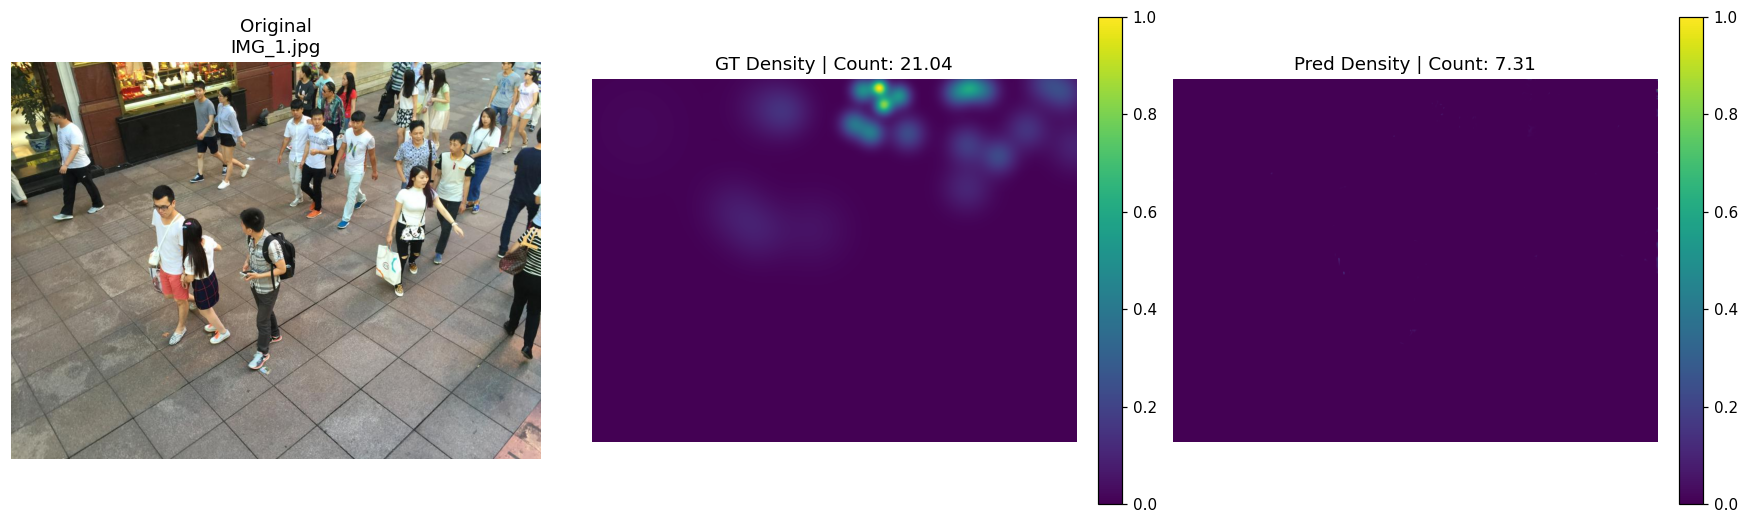

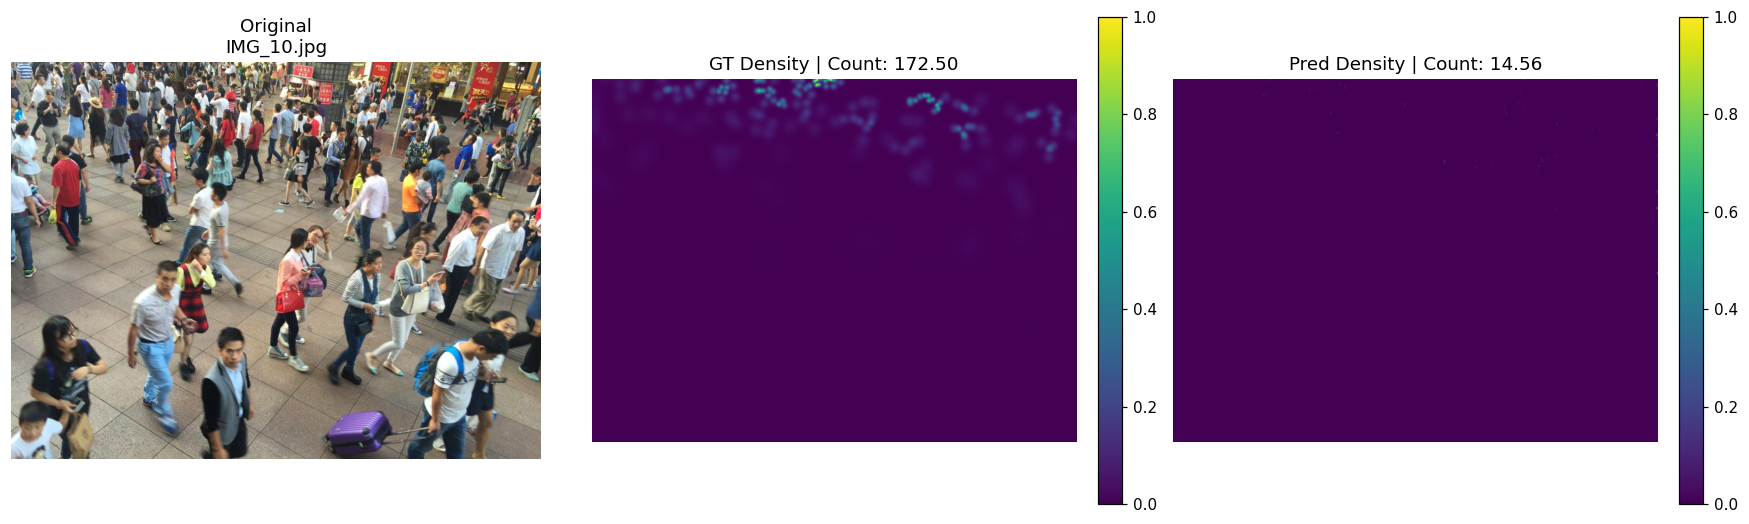

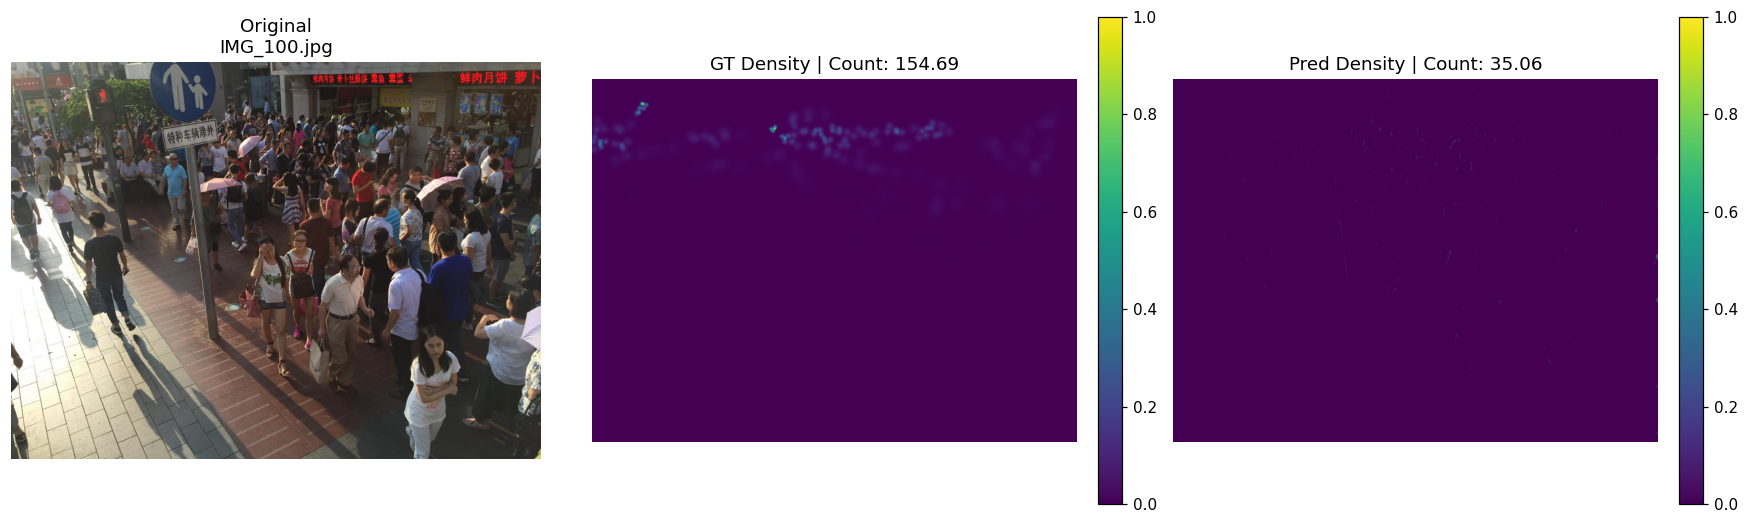

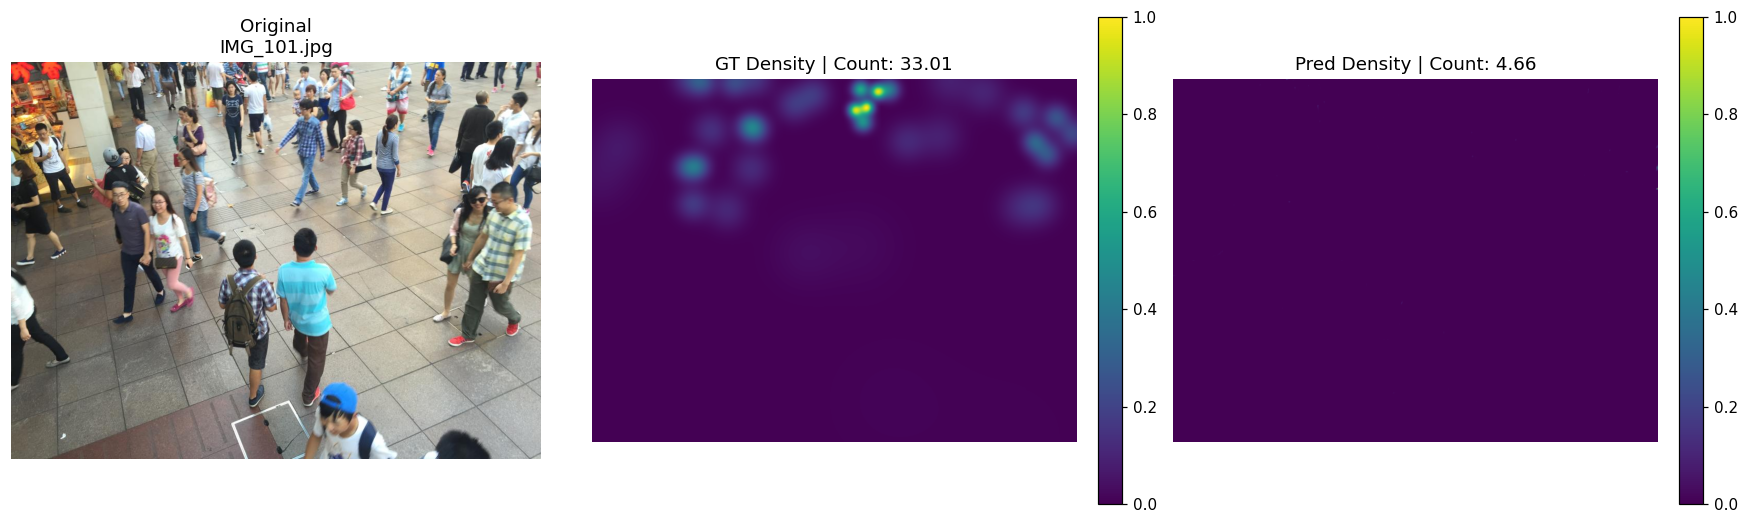

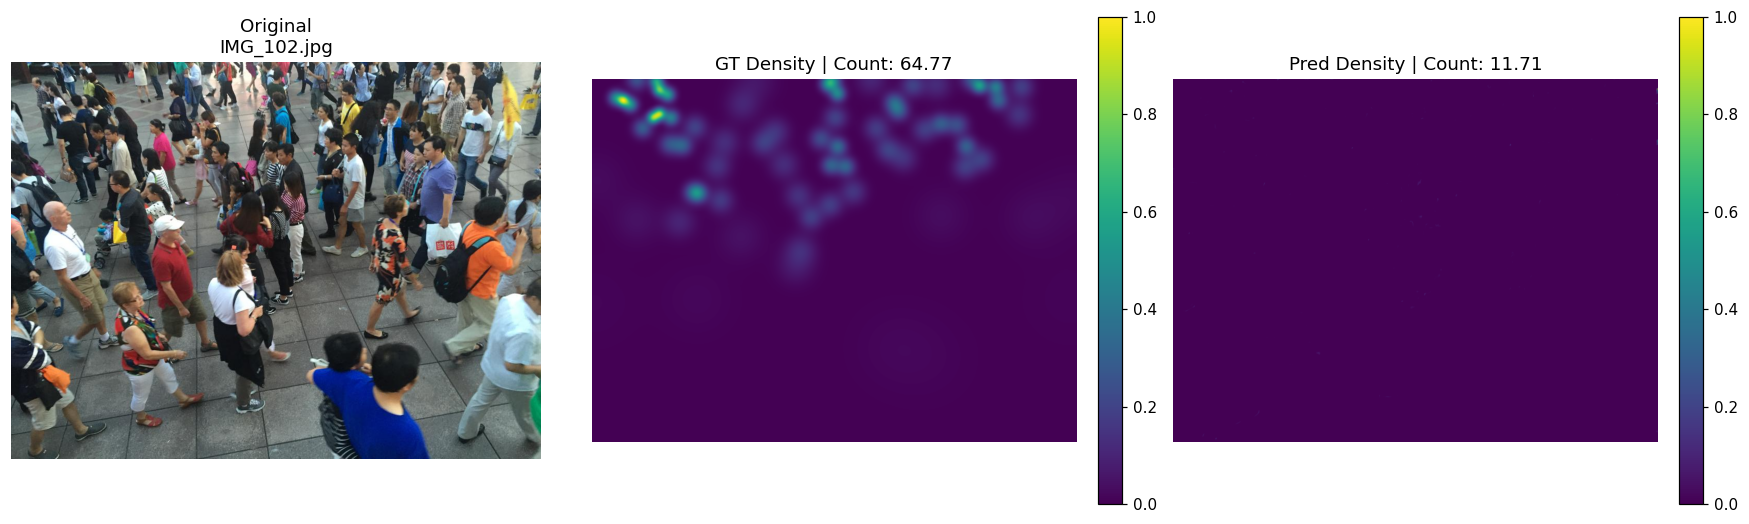

In [15]:
# Cell 15 — Visualize 5 test examples (Original | GT density | Pred density)

import matplotlib.pyplot as plt

def show_examples(pairs, num_examples=5, overlap=0.5):
    # pick first N (or shuffle if you prefer)
    sample_idxs = list(range(min(num_examples, len(pairs))))
    for idx in sample_idxs:
        ipath, gpath = pairs[idx]
        # Load native image & GT
        img = np.array(Image.open(ipath).convert("RGB"))
        H, W = img.shape[:2]
        pts = read_points_from_mat(gpath)
        gt_den = generate_density_adaptive(pts, H, W)
        gt_count = float(gt_den.sum())

        # Predict with native-resolution tiling
        pred_den = predict_density_tiled_native(img, model, tile_size=PATCH_SIZE, overlap=overlap)
        pred_count = float(pred_den.sum())

        # Simple normalization for visualization (doesn't affect counts)
        def norm_vis(x):
            x = x.squeeze(-1)
            m = x.max() if x.max() > 0 else 1.0
            return x / m

        gt_vis   = norm_vis(gt_den)
        pred_vis = norm_vis(pred_den)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=110)
        axes[0].imshow(img)
        axes[0].set_title(f"Original\n{Path(ipath).name}")
        axes[0].axis("off")

        im1 = axes[1].imshow(gt_vis, cmap="viridis")
        axes[1].set_title(f"GT Density | Count: {gt_count:.2f}")
        axes[1].axis("off")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        im2 = axes[2].imshow(pred_vis, cmap="viridis")
        axes[2].set_title(f"Pred Density | Count: {pred_count:.2f}")
        axes[2].axis("off")
        plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

# Run it:
show_examples(test_pairs, num_examples=5, overlap=0.5)